In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split

# Синтетические данные

In [99]:
def generate_binary_dataset(n: int = 100,
                            dependency_type: str = 'lines',
                            noise: float = 0.25,
                            rnd: int = 42):
    X, y = (None, None)
    
    if dependency_type == 'lines':
        X, y = make_classification(n, n_features=2, n_informative=2, n_redundant=0, 
                                   n_classes=2, n_clusters_per_class=1, class_sep=2,
                                   random_state=rnd)
    elif dependency_type == 'moons':
        X, y = make_moons(n_samples=n, noise=noise, random_state=rnd)
    elif dependency_type == 'circles':
        X, y = make_circles(n_samples=n, 
                             noise=noise, 
                             factor=0.5,
                             random_state=rnd)
        
    X += np.random.randn(*X.shape) * noise 
    return X, y

def draw_bClassification_dataset(
        ax,
        X,
        y,
        colors: tuple = ('red', 'blue'),
        title: str = None,
        labels: tuple = None,
    ):
    ax.set_title(title, fontdict={'size': 14})
    
    g1_indices = np.where(y == 1)
    g2_indices = np.where(y == 0)
    
    labels = labels or ('Group 1', 'Group 2')
    ax.scatter(X[g1_indices].T[0], X[g1_indices].T[1], c=colors[0], label=labels[0])
    ax.scatter(X[g2_indices].T[0], X[g2_indices].T[1], c=colors[1], label=labels[1])
    ax.legend()

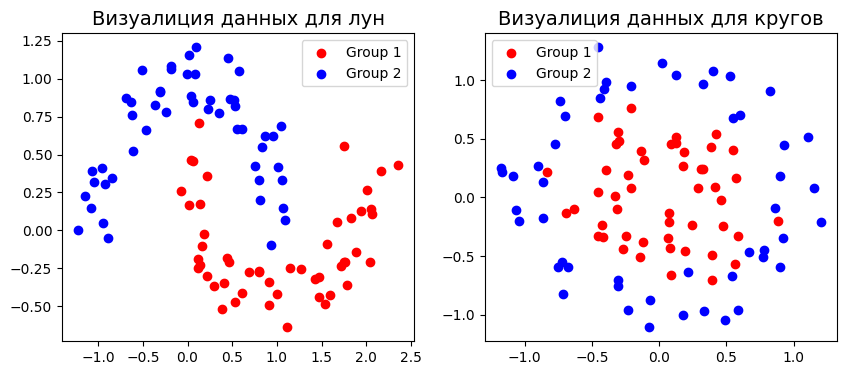

In [196]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

moons_ds = generate_binary_dataset(dependency_type='moons', noise=0.1)
circles_ds = generate_binary_dataset(dependency_type='circles', noise=0.1)

draw_bClassification_dataset(ax[0], moons_ds[0], moons_ds[1], title='Визуалиция данных для лун')
draw_bClassification_dataset(ax[1], circles_ds[0], circles_ds[1], title='Визуалиция данных для кругов')

In [227]:
# Utilities
def sigmoid(z):
        return 1 / (1 + np.e ** (-z))

def sigmoid_derivation(z):
    return sigmoid(z) - sigmoid(z) ** 2

# Создаим класс для регрессии
class LogisticRegression():
    """Logistic regression classifier"""
    
    def __init__(self, 
                 weights=None,
                 learning_rate=0.25, 
                 l1_penalty=0.0,
                 l2_penalty=0.0,
                 threshold=0.5,
                 batch_size=1000, 
                 n_batches=None,
                 random_state=42):
        
        self.weights = weights
        self.learning_rate = learning_rate
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        self.threshold = threshold
        self.batch_size = batch_size
        self.n_batches = n_batches
        self.random_state = random_state
        
    def _init_weights(self, n_features: int, rnd=42) -> np.array:
        """Init inital random weights"""
        
        np.random.seed(rnd)
        self.weights = np.random.randn(n_features)
        
        return self.weights

    def _sigmoid(self, z):
        """Plain sigmoid"""
        
        return 1 / (1 + np.e ** (-z))

    def _sigmoid_derivation(self, z):
        """Derivative of sigmoid function"""
        
        return self.sigmoid(z) - self.sigmoid(z) ** 2
    
    def loss(self, X, y_true):
        """Cross entropy loss function"""
        
        pass
    
    def loss_gradient(self, X, y_hat, y) -> np.array:
        """Gradient of loss function"""
        loss = 2 * np.dot(X.T, (y_hat - y)) / y.size
        print('X.T shape', X.T.shape)
        print('y_hat - y', (y_hat - y).shape)
        
        return loss
    
    def _update_weights(self, delta):
        """Updates weights including regulization"""
        
        l2_ = self.l2_penalty * np.sum(self.weights[1:])
        print('l2 ', l2_)
        l1_ = np.sign(self.weights) * self.l1_penalty
        print('l1 ', l1_)
        print('delta ', delta)
        delta = delta + l1_ + l2_
        self.weights -= self.learning_rate * delta
    
    def predict_prob(self, x) -> int:
        """Predict instance relation to class"""
        
        x = np.array(x)
        assert x.ndim == 1
        
        # Probably it should it be places somewhere else
        if x.shape[0] != self.weights.size:
            x = self._add_bias_to_x(x)
            assert x.shape[1] == self.weights.size
        
        arg = np.dot(x, self.weights.T)
        return sigmoid(arg)
    
    def _add_bias_to_x(self, X):
        """Adds bias to features instance"""
        X = np.atleast_2d(X)
        return np.column_stack((
            np.ones((X.shape[0], 1)),
            X
        ))
    
    def predict_class(self, x) -> int:
        """Predicts class of instance"""
        
        return self._logit(self.predict_prob(x))
        
    def fit(self, X, y_true, epsilon=1e-2, epochs=None):
        y_true = np.atleast_2d(y_true).T
        epochs = epochs or 0
        if self.weights is None:
            self._init_weights(X.shape[1] + 1) # + 1 adds bias
        
        while True:
            epochs -= 1
            
            y_hat = [self.predict_prob(x) for x in X]
            print('y_hat.shape', np.array(y_hat).shape)
            print('y.shape', np.array(y_true).shape)
            loss_gradient = self.loss_gradient(self._add_bias_to_x(X), y_hat=y_hat, y=y_true)
            self._update_weights(loss_gradient)
            
            if loss_gradient.sum() <= epsilon:
                break
            if epochs == 0:
                break
            
    def prediction_report(self, X, y) -> pd.array:
        predictions = np.array([self.predict_class(x) for x in X])
        
        tp = np.where((predictions == y) & predictions == 1).count
        return tp

In [268]:
X_train, X_test, y_train, y_test = train_test_split(moons_ds[0], 
                                                    moons_ds[1], 
                                                    test_size=0.3, 
                                                    random_state=42)
log_regr = LogisticRegression(learning_rate=0.25)
log_regr.fit(X_train, y_true=y_train, epochs=300)

log_regr.prediction_report(X_test, y_test)

y_hat.shape (70, 1)
y.shape (70, 1)
X.T shape (3, 70)
y_hat - y (70, 1)
l2  0.0
l1  [ 0. -0.  0.]
delta  [[ 0.12390838]
 [-0.50094111]
 [ 0.45279447]]


ValueError: non-broadcastable output operand with shape (3,) doesn't match the broadcast shape (3,3)

# Набор данных для Cars Moldova

In [107]:
cars_df = pd.read_csv('datasets/cars_moldova_updated.csv', sep=',')
cars_df['Style'].value_counts()

Sedan        9700
Universal    5818
Hatchback    5216
Crossover    4010
SUV          3037
Minivan      2628
Coupe         572
Microvan      422
Combi         341
Cabriolet     131
Pickup        121
Roadster       22
Name: Style, dtype: int64

In [269]:
x = np.random.randn(2)
y = np.random.randn(2)
x,y

(array([ 1.52302986, -0.23415337]), array([-0.23413696,  1.57921282]))